In [1]:
from skimage import io, measure, filters
from skimage.feature import peak_local_max
from skimage.morphology import watershed, disk
from skimage.filters import rank
from skimage.exposure import rescale_intensity
from scipy import ndimage as ndi

import matplotlib.pyplot as plt

import numpy as np

import pims

%matplotlib inline

In [3]:
from skimage.restoration import denoise_tv_chambolle

In [4]:
bright_stack = pims.TiffStack('test_stack.tif')
dim_stack = pims.TiffStack('dim_stack.tif')

In [5]:
denoised = denoise_tv_chambolle(dim_stack[0])

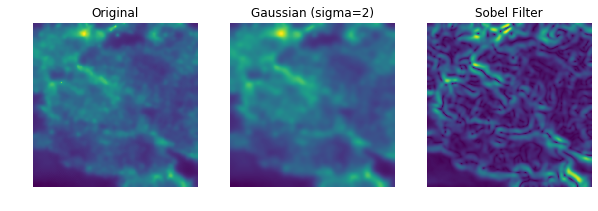

In [14]:
test = denoised
test = rescale_intensity(test)
test_blur = filters.gaussian(test, sigma=5)
#test_blur = rank.modal(test_blur, disk(5))
edges = filters.sobel(test_blur)

fig, axs = plt.subplots(1,3,figsize=(10,20))
axs[0].imshow(test)
axs[0].axis('off')
axs[0].set_title('Original')
axs[1].imshow(test_blur)
axs[1].axis('off')
axs[1].set_title('Gaussian (sigma=2)')
axs[2].imshow(edges)
axs[2].axis('off')
axs[2].set_title('Sobel Filter')
plt.show()

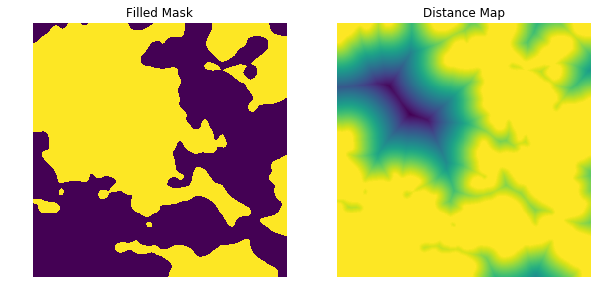

In [15]:
test_thresh = filters.threshold_li(test_blur)
test_thresh_filled = ndi.morphology.binary_fill_holes(test_blur>test_thresh)
dist_test_thresh = ndi.distance_transform_bf(test_thresh_filled)

fig, axs = plt.subplots(1,2,figsize=(10,15))
axs[0].imshow(test_thresh_filled)
axs[0].axis('off')
axs[0].set_title('Filled Mask')
axs[1].imshow(-dist_test_thresh)
axs[1].axis('off')
axs[1].set_title('Distance Map')
plt.show()

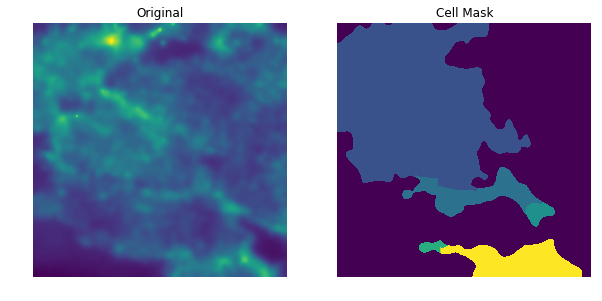

In [16]:
local_maxi = peak_local_max(dist_test_thresh, indices=False, footprint=np.ones((100, 100)),
                            labels=test_thresh_filled)
markers = ndi.label(local_maxi)[0]
labels = watershed(edges, markers, mask=test_thresh_filled)

fig, axs = plt.subplots(1,2,figsize=(10,15))
axs[0].imshow(test)
axs[0].axis('off')
axs[0].set_title('Original')
axs[1].imshow(labels)
axs[1].axis('off')
axs[1].set_title('Cell Mask')
plt.show()

In [25]:
def find_cells(fr, sigma=2, modal_size=5, cell_size=100):
    blurred_fr = filters.gaussian(rescale_intensity(fr), sigma=sigma)
#     blurred_fr = rank.modal(blurred_fr, disk(modal_size))
    edges_fr = filters.sobel(blurred_fr)
    thresh = filters.threshold_li(blurred_fr)
    thresh_fill_fr = ndi.morphology.binary_fill_holes(blurred_fr>thresh)
    dist_mat = ndi.distance_transform_bf(thresh_fill_fr)
    local_maxi = peak_local_max(dist_mat, indices=False, footprint=np.ones((cell_size, cell_size)),
                                labels=thresh_fill_fr)
    markers = ndi.label(local_maxi)[0]
    labels = watershed(edges_fr, markers, mask=thresh_fill_fr)
    
    return labels, edges_fr

Text(0.5, 1.0, 'Cells')

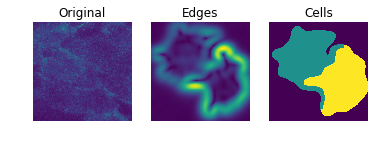

In [28]:
labels, edges = find_cells(bright_stack[0],sigma=20)
fig, axs = plt.subplots(1,3)
axs[0].imshow(dim_stack[0])
axs[0].axis('off')
axs[0].set_title('Original')
axs[1].imshow(edges)
axs[1].axis('off')
axs[1].set_title('Edges')
axs[2].imshow(labels)
axs[2].axis('off')
axs[2].set_title('Cells')